<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Equalization_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Notebook designed by Nicolas Menet in collaboration with Guy Revach.*

#Comparison of Equalization Techniques

## Signal generation

In [ ]:
pip install pydsm

     |████████████████████████████████| 552 kB 3.9 MB/s 
  Created wheel for pydsm: filename=pydsm-0.14.0.0-cp37-cp37m-linux_x86_64.whl size=684723 sha256=935653e00bbaedbee04739441223d6bb25b440ff5ae2cd94410aea08a4f16564
  Stored in directory: /root/.cache/pip/wheels/1d/37/8e/15939ed2fb3dcf8bbab167a0bf7c7155c2e6fa4df16d490260
Successfully built pydsm


Let us assume a signal $X[\cdot]$ of interest is filtered by a causal finite duration filter with impulse response $h$. To that we add i.i.d. gaussian noise $W[\cdot]$ with standard deviation $\sigma$. We thus observe $Y[\cdot] = \underbrace{(X * h)[\cdot]}_{Z[\cdot]} + W[\cdot]$ and wish to estimate $X$.

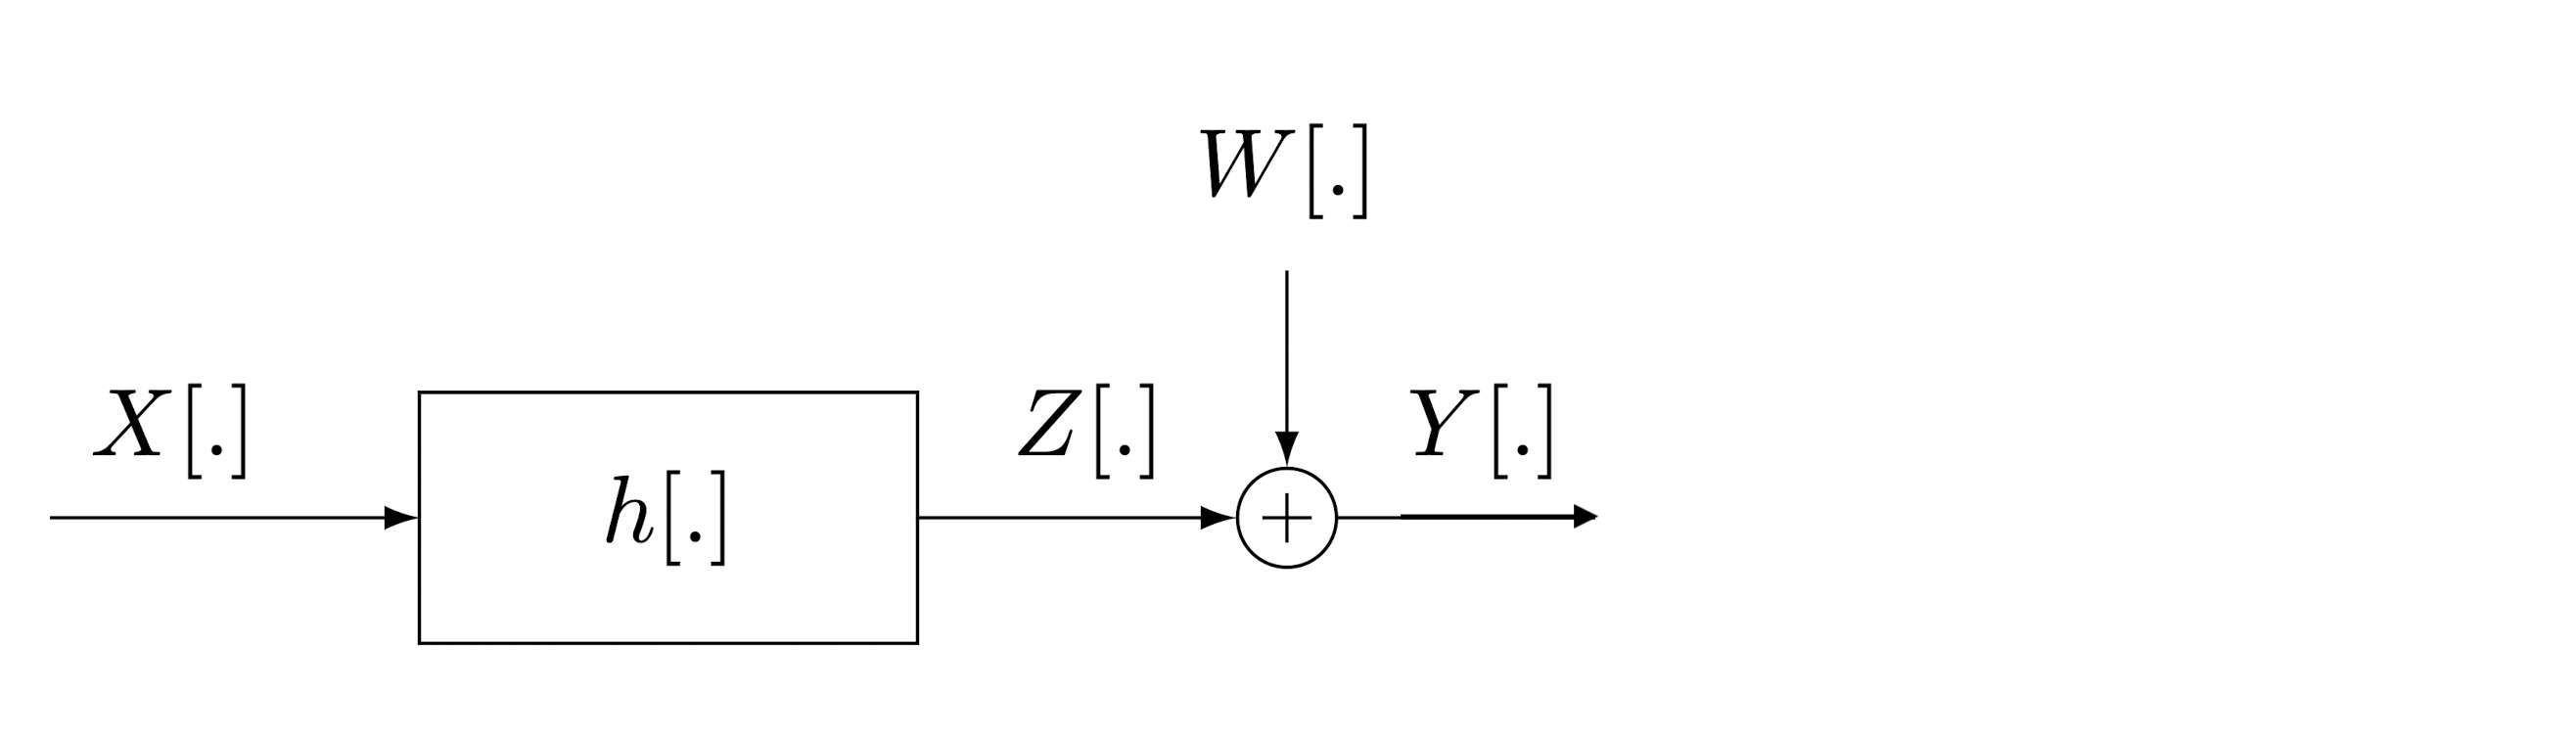

In order to be able to use all types of equalization techniques from the course we restrict ourselves to a digital signal, i.e. the signal is not only discrete time, but also only takes on values in a finite set called constellation.

In [ ]:
import ipywidgets as widgets
#read in parameters
#-------------------------------------------------------------------------------
NG = 0
MG = [1, -1] #message is binary as standard
xG = ""
hG = [1, 0.5]
sigmaG = 0.5

def update_parameters(M, h, x, sigma):
  global NG, MG, xG, hG, sigmaG
  try:
    MG = [float(v) for v in M.split()]
    hG = [float(v) for v in h.split()]
    xG = [float(v) for v in x.split()]
    for v in xG:
      if v not in MG:
        raise
    NG = len(xG)
    sigmaG = sigma
    print("")
  except:
    print("make sure the entered values are valid (e.g. x takes values in M)")
widgets.interact(update_parameters, M = '1 -1', h = '1 0.5', x  = widgets.Textarea(
    value='1 1 -1 -1 1 1 1 1 -1 -1 -1 -1 -1 1 1 1 1 -1 -1 -1 -1 -1 1 1 1 -1 1 1 1 -1 1 -1 1 -1',
    description='x'), sigma = widgets.FloatSlider(value=0.5, min=0, max=2));

interactive(children=(Text(value='1 -1', description='M'), Text(value='1 0.5', description='h'), Textarea(valu…

Above you can set the parameters of the equalization. $h$ is the impulse response of the causal FIR filter (given using taps), $M$ describes the constellation and $x$ is the original signal (supposing at $t < 0$ we pad with $0$ and after the indicated values we no longer care about $x$). Let us generate the received values $y$ by filtering with $h$ and adding gaussian noise afterwards.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


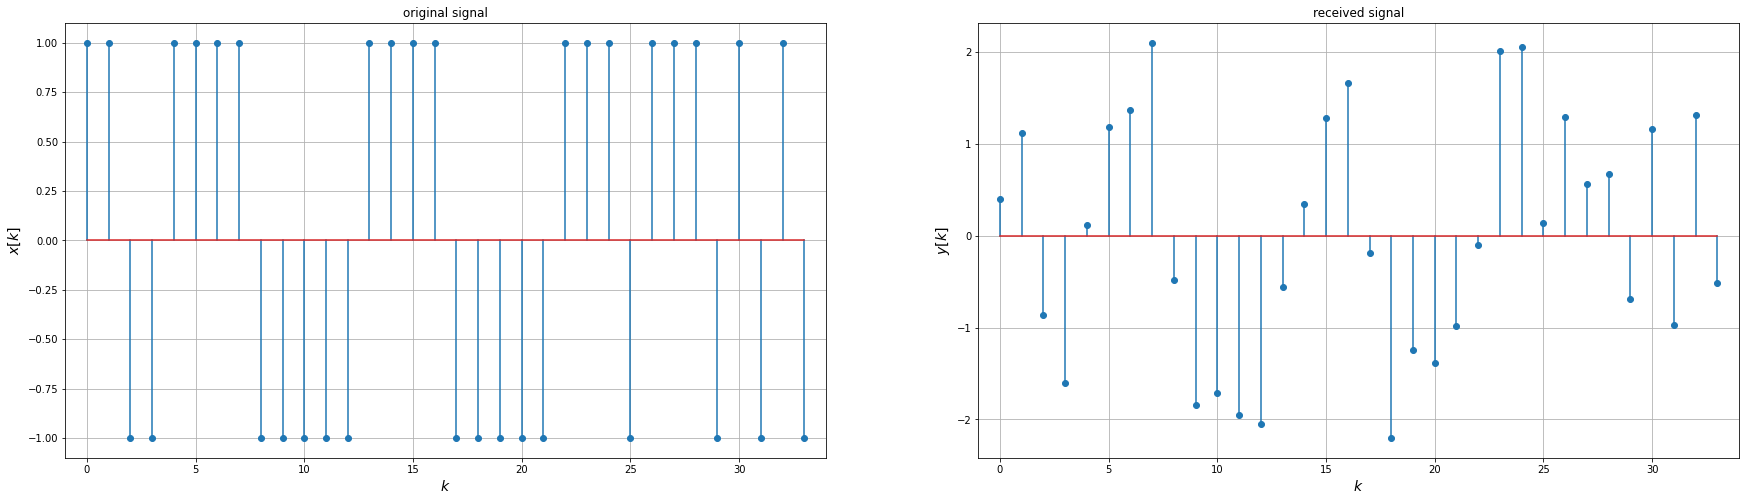

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#generate the signals
#-------------------------------------------------------------------------------
zG = np.convolve(xG, hG)
zG = zG[:len(xG)] #gets rid of values at end of signal about which we do not care
yG = zG + np.random.normal(0, sigmaG, zG.shape)

#plot the signals
#-------------------------------------------------------------------------------
fig = plt.figure(figsize=(30, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax1.grid()
ax1.set_title('original signal')
ax1.set_xlabel('$k$', fontsize=14)
ax1.set_ylabel('$x[k]$', fontsize=14)
ax1.axis(xmin=-1, xmax=len(xG))
ax1.stem(xG);

ax2 = fig.add_subplot(1, 2, 2)
ax2.grid()
ax2.set_title('received signal')
ax2.set_xlabel('$k$', fontsize=14)
ax2.set_ylabel('$y[k]$', fontsize=14)
ax2.axis(xmin=-1, xmax=len(yG))
ax2.stem(yG);

Now that the problem has been set up, let us go on and try to perform different kinds of equalization techniques that we have learnt in this course so far.

## Right Sided Inversion

In [ ]:
!gdown https://drive.google.com/uc?id=1RdNclKuMuZT4oI4UxzJfiS-WvDiMB1Ja

Downloading...
From: https://drive.google.com/uc?id=1RdNclKuMuZT4oI4UxzJfiS-WvDiMB1Ja
To: /content/right_sided_inversion_equalizer.py
100% 1.14k/1.14k [00:00<00:00, 2.03MB/s]


This technique of inversion completely neglects the introduced noise. We simply expand the inverted signal to the right.

In [ ]:
import  right_sided_inversion_equalizer

In [ ]:
right_sided_inversion_equalizer.set_parameters(hG)

right_sided_inversion_equalizer.g_right_sided_init()
g_right_sided = [right_sided_inversion_equalizer.g_right_sided_at(t) for t in range(-NG+1, NG)]

print("right sided inversion coefficients from index -len(y)+1 to len(y)-1:")
print(g_right_sided)

offset m set to 0
right sided inversion coefficients from index -len(y)+1 to len(y)-1:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, -0.5, 0.25, -0.125, 0.0625, -0.03125, 0.015625, -0.0078125, 0.00390625, -0.001953125, 0.0009765625, -0.00048828125, 0.000244140625, -0.0001220703125, 6.103515625e-05, -3.0517578125e-05, 1.52587890625e-05, -7.62939453125e-06, 3.814697265625e-06, -1.9073486328125e-06, 9.5367431640625e-07, -4.76837158203125e-07, 2.384185791015625e-07, -1.1920928955078125e-07, 5.960464477539063e-08, -2.9802322387695312e-08, 1.4901161193847656e-08, -7.450580596923828e-09, 3.725290298461914e-09, -1.862645149230957e-09, 9.313225746154785e-10, -4.656612873077393e-10, 2.3283064365386963e-10, -1.1641532182693481e-10]


Now let us apply the newfound filter. We get

In [ ]:
r_ = np.convolve(yG, g_right_sided)
delta = len(r_) - len(yG)
r_ = r_[delta//2: -delta//2]

x_right_sided = r_
print(x_right_sided)

[ 0.39509917  0.92459904 -1.3294329  -0.93793066  0.58753491  0.89105555
  0.91721924  1.64149776 -1.30484054 -1.18747308 -1.11706281 -1.39339058
 -1.35333083  0.11736943  0.28956885  1.13611023  1.09730021 -0.73949208
 -1.83224    -0.33263193 -1.21437998 -0.37958653  0.0891082   1.96546569
  1.07347833 -0.39829286  1.48743826 -0.17905134  0.76112463 -1.0644864
  1.69647909 -1.81764867  2.21895114 -1.6280161 ]


We compare the received values to the sent ones using the mean squared error.

In [ ]:
MSE_RIGHT_SIDED = np.square(np.subtract(x_right_sided, xG)).mean()
MSE_RIGHT_SIDED_dB = 10*np.log10(MSE_RIGHT_SIDED)
print("mean squared error with right sided inversion: ", MSE_RIGHT_SIDED, "or in dB: ", MSE_RIGHT_SIDED_dB)

mean squared error with right sided inversion:  0.33253973127315806 or in dB:  -4.781564585056967


## Robust Inversion

In [ ]:
!gdown https://drive.google.com/uc?id=1k3Ckkz6ki9KjembSkNQ6LMrbLtSYgqjQ

Downloading...
From: https://drive.google.com/uc?id=1k3Ckkz6ki9KjembSkNQ6LMrbLtSYgqjQ
To: /content/robust_equalizer.py
100% 1.09k/1.09k [00:00<00:00, 1.71MB/s]


In order to run robust inversion the robustness parameter $\sigma_R$ must be set first.

In [ ]:
sigma_RG = 1
def set_sigma_RG(sigma_R):
  global sigma_RG
  sigma_RG = sigma_R

widgets.interact(set_sigma_RG, 
  sigma_R = widgets.FloatSlider(
    value=1,
    min=0,
    max=5,
    step=0.01,
    description='sigma_R',
    readout_format ='.2f'));

interactive(children=(FloatSlider(value=1.0, description='sigma_R', max=5.0, step=0.01), Output()), _dom_class…

In [ ]:
import robust_equalizer

robust_equalizer.set_parameters(hG, sigma_RG)

g_robust = [robust_equalizer.g(t) for t in range(-NG+1, NG)]

print("robust inversion coefficients from index -len(y)+1 to len(y)-1:")
print(g_robust)

robust inversion coefficients from index -len(y)+1 to len(y)-1:
[2.2985086056692694e-17, -8.326672684688674e-17, 3.0682921481339775e-17, -1.713039432527097e-17, -3.3610267347050637e-18, -8.760353553682876e-17, 1.960237527853792e-16, -7.979727989493313e-17, 3.642919299551295e-17, -3.7816971776294395e-16, 1.8735013540549517e-15, -7.827072323607354e-15, 3.308638085730564e-14, -1.4125419584010146e-13, 6.028632454357918e-13, -2.571403593526478e-12, 1.0968613387354886e-11, -4.678709156213934e-11, 1.995732199291944e-10, -8.512922007944401e-10, 3.631241617292613e-09, -1.5489295114752555e-08, 6.607058611503291e-08, -2.818283427030027e-07, 1.2021569561430218e-06, -5.12787795948523e-06, 2.1873293861513626e-05, -9.330194441740935e-05, 0.00039798545601663765, -0.0016976326076573144, 0.007241361278441452, -0.030888493145329415, 0.13175685787554087, 0.43798263270539584, -0.10267870504982181, 0.024071540018802223, -0.005643225034788285, 0.0013229726377451158, -0.0003101518350646301, 7.271062004569895e

Now let us apply the newfound filter. We get

In [ ]:
x_robust = robust_equalizer.x_hat(yG)
print(x_robust)

[ 0.33626615  0.38535676 -0.69320768 -0.60283607  0.31924535  0.58819413
  0.76627407  0.78917395 -0.60143374 -0.89079882 -0.78055765 -0.97021244
 -0.80735648 -0.05603166  0.28916053  0.73221105  0.64303437 -0.48599706
 -1.03971759 -0.4879978  -0.6424921  -0.36895615  0.22855665  1.14910086
  0.67674021  0.05643686  0.63447836  0.22966198  0.1329773  -0.16878597
  0.42294727 -0.3754141   0.63772471 -0.39263403]


We compare the received values to the sent ones using the mean squared error.

In [ ]:
MSE_ROBUST = np.square(np.subtract(x_robust, xG)).mean()
MSE_ROBUST_dB = 10*np.log10(MSE_ROBUST)
print("mean squared error with Wiener filtering: ", MSE_ROBUST, "or in dB: ", MSE_ROBUST_dB)

mean squared error with Wiener filtering:  0.2989296916485747 or in dB:  -5.244309458549661


## Wiener Filter

From our analysis in previous notebooks or alternatively in the lecture notes on page 140 (as of 2020) we note that the Wiener filter for this problem coincides with robust inversion, however the robustness parameter $\sigma_R$ is set to $\sigma_R = \sigma$. Thus the variance in the i.i.d. Gaussian noise is responsible for the level of robustness required (seems reasonable right?).

In [ ]:
import robust_equalizer

robust_equalizer.set_parameters(hG, sigmaG)

g_wiener = [robust_equalizer.g(t) for t in range(-NG+1, NG)]

print("wiener filter coefficients from index -len(y)+1 to len(y)-1:")
print(g_wiener)

wiener filter coefficients from index -len(y)+1 to len(y)-1:
[4.460299317388117e-15, -1.1802191168808207e-14, 3.055845507193844e-14, -8.003667173461793e-14, 2.0909662890034042e-13, -5.474488050383197e-13, 1.4331123093791476e-12, -3.751353394587653e-12, 9.820661645010276e-12, -2.5711005373352247e-11, 6.731260687731222e-11, -1.7622655418270128e-10, 4.613668891373379e-10, -1.2078741999654863e-09, 3.1622560883325275e-09, -8.2788937524024e-09, 2.167442531833194e-08, -5.674438199095716e-08, 1.4855872057344122e-07, -3.8893177956716984e-07, 1.0182366178678598e-06, -2.6657780741847284e-06, 6.97909760429688e-06, -1.8271514739050254e-05, 4.7835446613067253e-05, -0.00012523482509950966, 0.0003278690286854444, -0.0008583722609568981, 0.0022472477541851665, -0.005883371001598317, 0.01540286525060984, -0.04032522475023137, 0.10557280900008414, 0.7236067977499789, -0.27639320225002106, 0.10557280900008405, -0.04032522475023133, 0.015402865250609868, -0.0058833710015982615, 0.0022472477541850416, -0.00

Now let us apply the newfound filter. We get

In [ ]:
x_wiener = robust_equalizer.x_hat(yG)
print(x_wiener)

[ 0.41612575  0.67200114 -1.05496532 -0.84401905  0.50029784  0.76508769
  0.93683209  1.25001744 -0.9707613  -1.14581021 -0.98239413 -1.28052808
 -1.12989172  0.01085501  0.32698829  0.98558192  0.94341059 -0.67594503
 -1.49924551 -0.47904246 -0.94182692 -0.4436452   0.19852441  1.65672162
  0.90756147 -0.12853739  1.04323515  0.14008341  0.33744918 -0.4931571
  0.93840984 -0.96300978  1.32192805 -0.9010613 ]


We compare the received values to the sent ones using the mean squared error.

In [ ]:
MSE_WIENER = np.square(np.subtract(x_wiener, xG)).mean()
MSE_WIENER_dB = 10*np.log10(MSE_WIENER)
print("mean squared error with Wiener filtering: ", MSE_WIENER, "or in dB: ", MSE_WIENER_dB)

mean squared error with Wiener filtering:  0.19811675400211945 or in dB:  -7.030787962282265


## LMS Equalization

In [ ]:
!gdown https://drive.google.com/uc?id=1yLrvj5InnE66yTFiBrKaEbQEGA0HU7Eg

Downloading...
From: https://drive.google.com/uc?id=1yLrvj5InnE66yTFiBrKaEbQEGA0HU7Eg
To: /content/LMS_equalizer.py
100% 1.89k/1.89k [00:00<00:00, 3.09MB/s]


To use LMS equalization we first have to run the filter in adaptive mode. While normally the filter would adjust to the data live (online learning) due to the limited size of our data we shall simulate additional data points prior to the data we already have and run the filter in adaptive mode on these (offline learning). To that end we simulate the transmission (as outlined above) numerically to then be able to feed both $y$ and $x$ to the filter.

In [ ]:
import numpy as np

x_sim = np.random.choice(MG, size = (NG*10)) #10 times the length of original signal may be used for training
z_sim = np.convolve(x_sim, hG)
z_sim = z_sim[:len(x_sim)] #gets rid of values at end of signal
y_sim = z_sim + np.random.normal(0, sigmaG, z_sim.shape)

print("x: ", x_sim[:10] , "...")
print("\nz: ",z_sim[:10], "...")
print("\ny: ",y_sim[:10], "...")

x:  [ 1.  1.  1.  1.  1. -1. -1. -1. -1.  1.] ...

z:  [ 1.   1.5  1.5  1.5  1.5 -0.5 -1.5 -1.5 -1.5  0.5] ...

y:  [ 0.95689309  1.75683667  0.98992383  1.1089061   1.1712598   0.2061229
 -1.713254   -1.99611281 -1.97786039 -0.42247307] ...


Having generated fake $X$ and $Y$ values, let us run LMS. To use LMS, we need to set initial coefficients for the equalization filter and a learning rate. To make matters simpler the coefficients will be initialized to 0, only the learning rate $\beta$ and the length of the inverse filter $len(g)$ may be adjusted.

In [ ]:
betaG = 0.025
lengG = len(hG)
def set_learning_rate(beta, leng):
  global betaG, lengG
  betaG, lengG = beta, leng

widgets.interact(set_learning_rate, 
  beta = widgets.FloatSlider(
    value=0.025,
    min=0,
    max=0.05,
    step=0.001,
    description='beta',
    readout_format ='.3f'),
  leng = widgets.IntSlider(
    value=len(hG),
    min=len(hG),
    max=10*len(hG),
    description='len(g)'));

interactive(children=(FloatSlider(value=0.025, description='beta', max=0.05, readout_format='.3f', step=0.001)…

Let us finally run the LMS algorithm. Hopefully a good learning rate and length of inversion filter was chosen.

/content/LMS_equalizer.py:41: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax1.stem(E);
/content/LMS_equalizer.py:50: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax2.stem(E**2);


final LMS coefficients:  [ 0.70717749 -0.27544456]


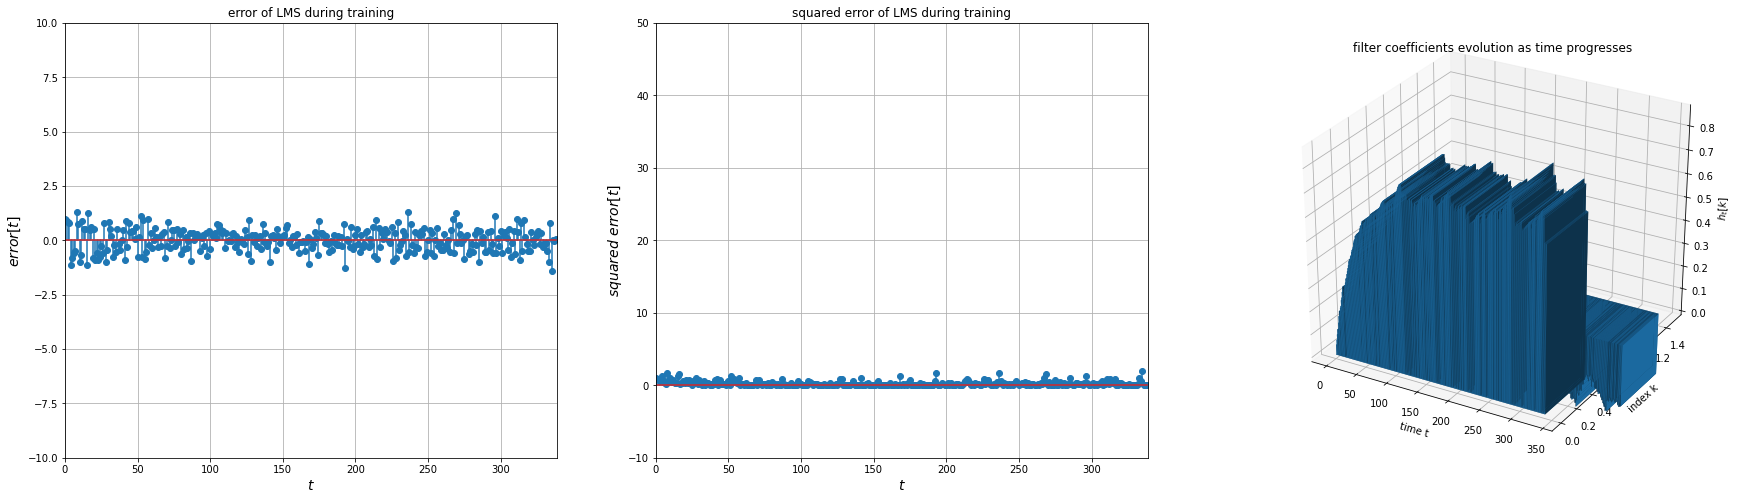

In [ ]:
import LMS_equalizer

G, E = LMS_equalizer.LMS_adapt(y_sim, x_sim, np.zeros(lengG), betaG);
LMS_equalizer.plot_LMS(G, E)

g_lms_final = G[-1]

print("final LMS coefficients: ", g_lms_final)

Now that we trained the coefficients using LMS let us perform the estimation on the actual received signal $Y$.

In [ ]:
x_lms = np.convolve(yG, g_lms_final)
x_lms = x_lms[:len(yG)]
print(x_lms)

[ 0.27940524  0.68473033 -0.92230694 -0.89450878  0.52529017  0.80522081
  0.63735096  1.10978741 -0.92080188 -1.16779074 -0.70305017 -0.90912491
 -0.91208603  0.16914702  0.40033212  0.80989532  0.82488632 -0.59367222
 -1.50462857 -0.27656417 -0.63243516 -0.31752095  0.20060001  1.4491739
  0.90045723 -0.46846607  0.8729167   0.04446737  0.319405   -0.668644
  1.01170458 -1.00622675  1.19351065 -0.72756749]


We compare the received values to the sent ones using the mean squared error.

In [ ]:
MSE_LMS = np.square(np.subtract(x_lms, xG)).mean()
MSE_LMS_dB = 10*np.log10(MSE_LMS)
print("mean squared error with LMS: ", MSE_LMS, "or in dB: ", MSE_LMS_dB)

mean squared error with LMS:  0.19380165240033773 or in dB:  -7.126425243683844


## Viterbi Equalization

In [ ]:
!gdown https://drive.google.com/uc?id=13hHW9STc3wfArt1gw0hynjSV74pwX3M6

Downloading...
From: https://drive.google.com/uc?id=13hHW9STc3wfArt1gw0hynjSV74pwX3M6
To: /content/viterbi_equalizer.py
100% 6.51k/6.51k [00:00<00:00, 11.4MB/s]


In [ ]:
import viterbi_equalizer

viterbi_equalizer.set_parameters(NG, MG, yG, hG)
with viterbi_equalizer.HiddenPrints():
  state_descriptions, branch_metrics = viterbi_equalizer.construct_trellis();
  x_viterbi = viterbi_equalizer.invoke_viterbi(state_descriptions, branch_metrics);

print(x_viterbi)

[1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0]


We compare the received values to the sent ones using the mean squared error.

In [ ]:
MSE_VITERBI = np.square(np.subtract(x_viterbi, xG)).mean()
MSE_VITERBI_dB = 10*np.log10(MSE_VITERBI)
print("mean squared error with Viterbi: ", MSE_VITERBI, "or in dB: ", MSE_VITERBI_dB)

mean squared error with Viterbi:  0.23529411764705882 or in dB:  -6.283889300503115


## Summary

Now that we applied each of the equalization techniques, let us show the results together such that we may compare them. Let us first examine the reconstructed signal.

In [ ]:
def update_parameters(logPlot):
  global logPlotG
  logPlotG = logPlot

widgets.interact(update_parameters,
  logPlot = widgets.Checkbox(
    value=False,
    description='logarithmic plot')
);

interactive(children=(Checkbox(value=False, description='logarithmic plot'), Output()), _dom_classes=('widget-…

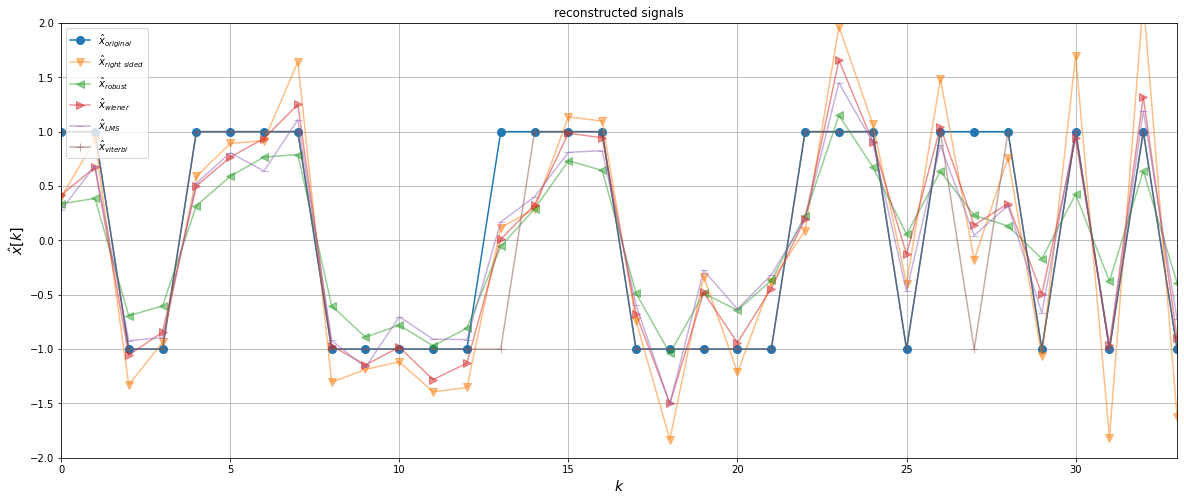

In [ ]:
fig = plt.figure(figsize=(20, 8))

plt.grid()
plt.title('reconstructed signals')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$\hat{x}[k]$', fontsize=14)
if logPlotG == False:
  plt.axis([0, len(xG)-1, 2*min(xG), 2*max(xG)])
  plt.plot(xG, alpha=1, marker='o', markersize=8);
  plt.plot(x_right_sided, alpha=0.5, marker='v', markersize=8);
  plt.plot(x_robust, alpha=0.5, marker='<', markersize=8);
  plt.plot(x_wiener, alpha=0.5, marker='>', markersize=8);
  plt.plot(x_lms, alpha=0.5, marker='_', markersize=8);
  plt.plot(x_viterbi, alpha=0.5, marker='+', markersize=8);

else:
  plt.semilogy(xG, alpha=1, marker='o', markersize=8);
  plt.semilogy(x_right_sided, alpha=0.5, marker='v', markersize=8);
  plt.semilogy(x_robust, alpha=0.5, marker='<', markersize=8);
  plt.semilogy(x_wiener, alpha=0.5, marker='>', markersize=8);
  plt.semilogy(x_lms, alpha=0.5, marker='_', markersize=8);
  plt.semilogy(x_viterbi, alpha=0.5, marker='+', markersize=8);


plt.legend(['$\hat{x}_{original}$', '$\hat{x}_{right\ sided}$', '$\hat{x}_{robust}$', '$\hat{x}_{wiener}$', '$\hat{x}_{LMS}$', '$\hat{x}_{viterbi}$']);

Even more concise is the mean squared error. They are listed next:


In [ ]:
print("mean squared error with right sided inversion:\t", MSE_RIGHT_SIDED, "\t or in dB:", MSE_RIGHT_SIDED_dB)
print("mean squared error with robust inv. filtering:\t", MSE_ROBUST, "\t or in dB:", MSE_ROBUST_dB)
print("mean squared error with Wiener filtering:\t", MSE_WIENER, "\t or in dB:", MSE_WIENER_dB)
print("mean squared error with LMS:\t\t\t", MSE_LMS, "\t or in dB:", MSE_LMS_dB)
print("mean squared error with Viterbi:\t\t", MSE_VITERBI, "\t or in dB:", MSE_VITERBI_dB)

mean squared error with right sided inversion:	 0.33253973127315806 	 or in dB: -4.781564585056967
mean squared error with robust inv. filtering:	 0.2989296916485747 	 or in dB: -5.244309458549661
mean squared error with Wiener filtering:	 0.19811675400211945 	 or in dB: -7.030787962282265
mean squared error with LMS:			 0.19380165240033773 	 or in dB: -7.126425243683844
mean squared error with Viterbi:		 0.23529411764705882 	 or in dB: -6.283889300503115
